## Import Library

In [42]:
import numpy as np
import pandas as pd 
import re
import os
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

## Load the Data Sets

In [43]:
lines=pd.read_csv("Hindi_English_Truncated_Corpus.csv",encoding='utf-8')

In [44]:
len(lines)

127607

In [45]:
lines['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [46]:
lines = lines[lines['source'].isin(['ted', 'tides'])]

In [47]:
lines.head(20)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
5,tides,The then Governor of Kashmir resisted transfer...,कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का व...
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
9,tides,You may want your child to go to a school that...,हो सकता है कि आप चाहते हों कि आप का नऋर्नमेनटे...
10,tides,Please ensure that you use the appropriate form .,कृपया यह सुनिश्चित कर लें कि आप सही फॉर्म का प...
13,ted,So there is some sort of justice,तो वहाँ न्याय है
14,tides,The first two were found unreliable and the pr...,पहले दो को अविश्वसनीय मानकर बाकी पांच मुखबिरों...
15,tides,They had justified their educational policy of...,कम संख़्या वाले उच्च एवं मध्यम श्रेणी के लोगों...


In [48]:
len(lines)

89881

In [49]:
# Count the null values in each column
pd.isnull(lines).sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [50]:
# Select record with Not Null values
lines=lines[~pd.isnull(lines['english_sentence'])]

In [51]:
# Drop the duplicates record
lines.drop_duplicates(inplace=True)

In [52]:
# Filter 50K Records
lines=lines.sample(n=50000,random_state=42)
lines.shape

(50000, 3)

## Preprocess the Datasets

In [53]:
# Lowercase all characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.lower())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.lower())

In [54]:
# Remove quotes
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub("'", '', x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

In [55]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines['english_sentence']=lines['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [56]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.translate(remove_digits))
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english_sentence']=lines['english_sentence'].apply(lambda x: x.strip())
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: x.strip())
lines['english_sentence']=lines['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi_sentence']=lines['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [57]:
# Add start and end tokens to target sequences
lines['hindi_sentence'] = lines['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')

In [58]:
lines.head()

,source,english_sentence,hindi_sentence
8527,tides,all kinds of back pain are a primary symptom o...,START_ सभी प्रकार का कमर दर्द इस रोग का प्रमुख...
52948,tides,early in march the mahatma served his historic...,START_ मार्च के प्रारंभ में महात्मा गांधी ने ब...
11574,ted,in cities in their own communities,START_ अपने शहरों और अपने ही देशों मे। _END
32922,ted,of hip hop artist william into their studio,START_ अपने स्टूडियो में हिप हॉप कलाकार विलइऍम...
92845,tides,this was a joint protest by the orthodox of bo...,START_ यह जुलूस दोनों धर्मों के कट्टरपंथियों क...


In [59]:
### Get English and Hindi Vocabulary
all_eng_words=set()
for eng in lines['english_sentence']:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

all_hindi_words=set()
for hin in lines['hindi_sentence']:
    for word in hin.split():
        if word not in all_hindi_words:
            all_hindi_words.add(word)

In [60]:
print("Count of English Word : ",len(all_eng_words))
print("Count of Hindi Word : ",len(all_hindi_words))

Count of English Word :  38500
Count of Hindi Word :  53008


In [61]:
lines['length_eng_sentence']=lines['english_sentence'].apply(lambda x:len(x.split(" ")))
lines['length_hin_sentence']=lines['hindi_sentence'].apply(lambda x:len(x.split(" ")))

In [62]:
lines.head()

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
8527,tides,all kinds of back pain are a primary symptom o...,START_ सभी प्रकार का कमर दर्द इस रोग का प्रमुख...,24,27
52948,tides,early in march the mahatma served his historic...,START_ मार्च के प्रारंभ में महात्मा गांधी ने ब...,31,33
11574,ted,in cities in their own communities,START_ अपने शहरों और अपने ही देशों मे। _END,6,9
32922,ted,of hip hop artist william into their studio,START_ अपने स्टूडियो में हिप हॉप कलाकार विलइऍम...,8,10
92845,tides,this was a joint protest by the orthodox of bo...,START_ यह जुलूस दोनों धर्मों के कट्टरपंथियों क...,33,42


In [63]:
lines[lines['length_eng_sentence']>30].shape

(5187, 5)

In [64]:
lines=lines[lines['length_eng_sentence']<=20]
lines=lines[lines['length_hin_sentence']<=20]

In [65]:
lines.shape

(32718, 5)

In [66]:
print("maximum length of Hindi Sentence ",max(lines['length_hin_sentence']))
print("maximum length of English Sentence ",max(lines['length_eng_sentence']))

maximum length of Hindi Sentence  20
maximum length of English Sentence  20


In [67]:
max_length_src=max(lines['length_hin_sentence'])
max_length_tar=max(lines['length_eng_sentence'])

In [68]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(38500, 53008)

In [69]:
num_decoder_tokens += 1 #for zero padding
num_encoder_tokens = num_encoder_tokens + 1

In [70]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [71]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [72]:
lines = shuffle(lines)
lines.head(10)

,source,english_sentence,hindi_sentence,length_eng_sentence,length_hin_sentence
118921,ted,take obiang junior well he didnt end up,START_ छोटे ओबीयांग को ही लीजिये। उनके पास _END,8,9
57328,ted,we just put a blind person in it and were done...,START_ हमे बस एक नेत्रहीन को चलाने देना है और ...,12,15
123120,ted,percent of the family income is just to cover ...,START_ प्रतिशत पारिवारिक कमाई केवल बिजली और _END,12,8
120978,ted,we probably cant do a lot for you with these t...,START_ तो शायद हम इन उपचारो से आप के लिए कुछ अ...,11,16
52580,ted,we did a study a scientifically designed process,START_ हमने एक अध्ययन किया वैज्ञानिक पद्धति से...,8,9
94496,tides,that leads us of course to consider what is re...,START_ इसलिए यहां निश्चय ही सोचने की बात यह है...,12,17
40885,ted,fully half are no longer being whispered into ...,START_ बैठकर देख सकते हैं कि उन भाषाओं में से ...,12,14
46684,ted,only after meeting your physiological needs an...,START_ केवल जब आप अपनी शारीरिक और आर्थिक ज़रूर...,9,13
115965,ted,ive been intrigued by this question,START_ मैं इस सवाल को लेकर अचंभे में हूं _END,6,10
23993,ted,blue means theyre working on it no need to worry,START_ नीले रंग का मतलब है कि वो सीख रहा है चि...,10,18


## Split the data into train and test

In [73]:
X, y = lines['english_sentence'], lines['hindi_sentence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((26174,), (6544,))

In [74]:
## Let us save this data
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')

In [75]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

## Encoder-Decoder Architecture

In [76]:
latent_dim = 300

In [77]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [78]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [79]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [80]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 300)    11550300    ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 300)    15902700    ['input_4[0][0]']                
                                                                                            

## Model Training

In [81]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [82]:
%%time
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/home/sunil/sunil2_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
204/204 [==============================] - 747s 4s/step - loss: 7.4448 - val_loss: 6.8374
Epoch 2/50
204/204 [==============================] - 766s 4s/step - loss: 6.7709 - val_loss: 6.7834
Epoch 3/50
204/204 [==============================] - 744s 4s/step - loss: 6.7218 - val_loss: 6.7640
Epoch 4/50
204/204 [==============================] - 772s 4s/step - loss: 6.6976 - val_loss: 6.7643
Epoch 5/50
204/204 [==============================] - 920s 5s/step - loss: 6.6802 - val_loss: 6.7524
Epoch 6/50
204/204 [==============================] - 951s 5s/step - loss: 6.6658 - val_loss: 6.7433
Epoch 7/50
204/204 [==============================] - 921s 5s/step - loss: 6.6369 - val_loss: 6.6922
Epoch 8/50
204/204 [==============================] - 918s 5s/step - loss: 6.5633 - val_loss: 6.6082
Epoch 9/50
204/204 [==============================] - 938s 5s/step - loss: 6.4767 - val_loss: 6.5384
Epoch 10/50
204/204 [==============================] - 952s 5s/step - loss: 6.4022 - val_lo

In [92]:
model.save_weights('nmt_weights3_50.h5')

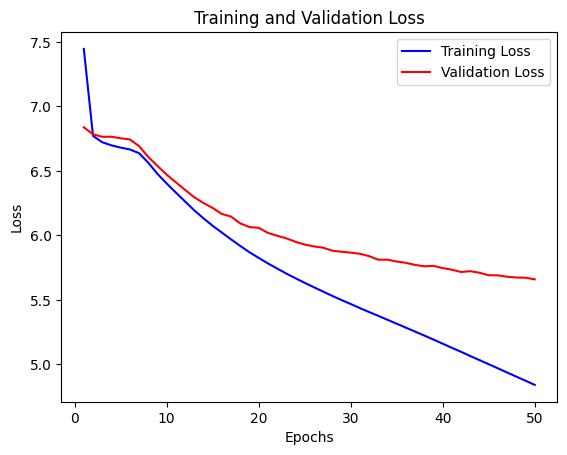

In [93]:
# Get the training and validation loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the loss curve
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [113]:
model.save('MT_Eng_Hindi_50.3.h5')

In [101]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [102]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

## BLEU Score Calculation

In [105]:
import sacrebleu
def calculate_bleu(reference, hypothesis):
    bleu = sacrebleu.corpus_bleu(hypothesis, [reference])
     # Print the BLEU score
    x = bleu.score/100
    print("BLEU Score:",x) 

## Machine Translation Testing

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [106]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Hindi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Hindi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 33ms/step
Input English sentence: it has an app a web and mobile app
Actual Hindi Translation: [' बोस्टन में एक एप्प है जो वेब और मोबाइल फ़ोन के लिए अनुप्रयोग है ']
Predicted Hindi Translation: [' यह एक ही एक और एक और एक ही बात की ']
BLEU Score: 0.03393026569182827


In [109]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Hindi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Hindi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 34ms/step
Input English sentence: they roam about widely in search of food
Actual Hindi Translation: [' इस जाति के पक्षी भोजन की खोज में दूर दूर तक घूमते हैं ']
Predicted Hindi Translation: [' वे से अधिक अलग अलग हो जाते हैं ']
BLEU Score: 0.029559265264674433


In [110]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Hindi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Hindi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 34ms/step
Input English sentence: it was about tons in other countries of the british empire
Actual Hindi Translation: [' ब्रिटिश साम्राज्य के अन्य देशों में यह लगभग टन थी ']
Predicted Hindi Translation: [' इस प्रकार की उम्र में भारत में भी थे ']
BLEU Score: 0.04266331692956901


In [111]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
reference = y_train[k:k+1].values[0][6:-4]
reference = [reference]
print('Actual Hindi Translation:', reference)
predicted = decoded_sentence[:-4]
predicted = [predicted]
print('Predicted Hindi Translation:', predicted)
calculate_bleu(reference, predicted)

1/1 [==============================] - 0s 34ms/step
Input English sentence: is that india will be the only country in the world
Actual Hindi Translation: [' कि भारत दुनिया में अकेला देश होगा ']
Predicted Hindi Translation: [' यह एक ही है कि इस प्रकार के लिए ']
BLEU Score: 0.04767707020457095
